### CCTS 40500: FINAL
#### Abdallah Aboelela

In [59]:
# General
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, RepeatVector
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# Sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Distances
import jellyfish as jf

In [9]:
# setup
seed = 1234
files = ['hiv-db-LTNP.seq', 'hiv-db-SP.seq', 'hiv-db-zRP.seq']

In [5]:
# load dataset
combined = pd.DataFrame()
for fname in files:
    df = pd.read_csv('data/' + fname, header = None)
    df['type'] = fname
    combined = pd.concat([combined, df])
    
combined = combined.replace('hiv-db-LTNP.seq', 'LTNP')
combined = combined.replace('hiv-db-zRP.seq', 'RP')
combined = combined.replace('hiv-db-SP.seq', 'SP')

combined.columns = ['seq', 'type']
combined['len'] = combined.seq.apply(len)

In [6]:
for i in range(max(combined.len)):
    combined[i] = combined.seq.apply(lambda x: get_position(x, i))
    
combined = combined.drop(['seq', 'len'], axis = 1)

In [7]:
combined.head()

,type,0,1,2,3,4,5,6,7,8,...,9830,9831,9832,9833,9834,9835,9836,9837,9838,9839
0,LTNP,A,A,G,C,G,A,A,A,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LTNP,C,C,C,G,A,A,C,A,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LTNP,A,A,A,C,C,A,G,A,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LTNP,A,C,A,G,G,G,A,C,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LTNP,T,G,A,A,A,A,C,A,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
combined = combined.replace(['A', 'T', 'G', 'C', np.nan], list(range(5))).reset_index(drop = True)

#### Attempt using random forest

In [11]:
rf_clf = RandomForestClassifier(n_estimators = 50)
kfold = KFold(n_splits=10, shuffle=True, random_state = seed)
results = cross_val_score(rf_clf, combined.drop('type', axis = 1), combined.type, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 74.12% (12.62%)


#### Attempt at Neural Net

In [12]:
k_clf = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(k_clf, combined.drop('type', axis = 1), combined.type, cv=kfold, error_score = 'raise')
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Baseline: 50.93% (18.00%)


## Creating a single layer auto-encoder/decoder
##### I tried a multi-layer autoencoder and it performed much worse using all these "tests" to see whether the newly generated sequences are appropriate so I'll be sticking with the signle layer model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(combined.drop('type', axis = 1), 
                                                    combined.type, random_state=seed)

In [14]:
input_img = Input(shape=(9840,))
encoded = Dense(4920, activation='relu')(input_img)
decoded = Dense(9840, activation='sigmoid')(encoded)
single_autoencoder = Model(input_img, decoded)

In [15]:
single_autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

In [16]:
single_autoencoder.fit(X_train, X_train,
                       epochs=25,
                       batch_size=256,
                       shuffle=True,
                       validation_data=(X_test, X_test))

Train on 101 samples, validate on 34 samples
Epoch 1/25
101/101 [==============================] - 8s 77ms/step - loss: 132276.8594 - val_loss: 145749.9844
Epoch 2/25
101/101 [==============================] - 2s 20ms/step - loss: 147450.6875 - val_loss: 129507.5703
Epoch 3/25
101/101 [==============================] - 2s 18ms/step - loss: 131312.0938 - val_loss: 127760.9531
Epoch 4/25
101/101 [==============================] - 2s 18ms/step - loss: 129686.7031 - val_loss: 127664.0000
Epoch 5/25
101/101 [==============================] - 2s 17ms/step - loss: 129573.4688 - val_loss: 127606.0703
Epoch 6/25
101/101 [==============================] - 2s 17ms/step - loss: 129489.7344 - val_loss: 127507.1016
Epoch 7/25
101/101 [==============================] - 2s 19ms/step - loss: 129348.6406 - val_loss: 127397.8984
Epoch 8/25
101/101 [==============================] - 2s 18ms/step - loss: 129184.2578 - val_loss: 127230.3359
Epoch 9/25
101/101 [==============================] - 2s 19ms/step 

In [17]:
decoded_imgs = pd.DataFrame(single_autoencoder.predict(X_test) * 5 // 1) # generating and cleaning

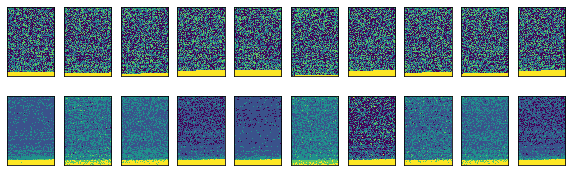

In [18]:
n = 10  # how many sequences we will display
plt.figure(figsize=(10, 3))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.array(X_test.iloc[i]).reshape(120, 82))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.array(decoded_imgs.iloc[i]).reshape(120, 82))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##### They look fairly similar, and it seems that the model is able to caputre the missing bottoms fairly well. Though maybe not the overall structure of the genotypes.

#### Next, we look at the proportion of nucleotides that are captured exactly using our autencoder. Furthermore, how well do our random forest and keras classifiers do at classifiying these? (A similar number to above would indicate that the training data is similar to the newly generated data




In [19]:
# Check what appropriate props would be for real data
combos = [('LTNP', 'LTNP'), ('LTNP', 'RP'), ('LTNP', 'SP'), ('RP', 'RP'), ('RP', 'SP'), ('SP', 'SP')]
for pheno1, pheno2 in combos:
    pheno_props = []
    for main_row in combined[combined.type == pheno1].iterrows():
        for check_row in combined[combined.type == pheno2].iterrows():
            pheno_props.append(np.array(main_row[1] == check_row[1]).mean())

    print(pheno1 + '/' + pheno2 + ': ' + str(np.array(pheno_props).mean()))

LTNP/LTNP: 0.3264196840881121
LTNP/RP: 0.3068776440134988
LTNP/SP: 0.29707447514580937
RP/RP: 0.4145130567716443
RP/SP: 0.3152387542292291
SP/SP: 0.35074121185728174


In [20]:
# Proportion of nucleotides identical in decoded (newly generated) and existing sequences
decoded_imgs.index = X_test.index
(decoded_imgs == X_test).mean(axis = 1)

32     0.272256
63     0.277947
68     0.255081
94     0.350000
66     0.297154
6      0.245427
78     0.550000
29     0.285772
62     0.261179
85     0.348882
125    0.749187
89     0.404167
91     0.399695
95     0.281707
40     0.287398
108    0.703252
83     0.290041
102    0.300711
54     0.637805
99     0.325813
98     0.298069
42     0.278150
35     0.251728
8      0.254675
52     0.644106
24     0.235772
22     0.433537
86     0.539431
36     0.509350
27     0.238415
77     0.263516
51     0.635976
48     0.291057
101    0.563415
dtype: float64

##### As expected, these aren't very helpful. Next, we attempt to use our classifiers, and then Jaro-Winkler distance (as a replacement for BLAST/Needleman-Wunsch which I couldn't figure out how to use in Python

I think that Jaro-Winkler distance (or even better, Levanshtein distance on a computer with more resources) would work in a similar fashion to Needleman-Wunsch because it's a measure of string edits

In [21]:
# Fitting clfs
rf_clf.fit(combined.drop('type', axis = 1), combined.type)
print(rf_clf.score(decoded_imgs, y_test))
k_clf.fit(combined.drop('type', axis = 1), combined.type)
print(k_clf.score(decoded_imgs, y_test))

0.6470588235294118
0.4411764762857381


##### The keras classifier does about a little worse than chance, whereas the Random Forest classifier does twice as well as chance (though still not as well as it did on the original data). However, it does much better than expected. Next, I try Jaro-Winkler distance, which is a measure of string edit distance (computationally more efficient than Levenshtein - which would be better in this case)

For reference, 0 represents two completely dissimilar strings and 1 represents identical strings.
The documentation is here: https://jellyfish.readthedocs.io/en/latest/comparison.html#levenshtein-distance

In [48]:
# Check what appropriate props would be for real data
combos = [('LTNP', 'LTNP'), ('LTNP', 'RP'), ('LTNP', 'SP'), ('RP', 'RP'), ('RP', 'SP'), ('SP', 'SP')]
for pheno1, pheno2 in combos:
    pheno_dists = []
    for main_row in combined[combined.type == pheno1].iterrows():
        for check_row in combined[combined.type == pheno2].iterrows():
            s1 = ''.join(list(main_row[1][1:].astype(str)))
            s2 = ''.join(list(check_row[1][1:].astype(str)))
            
            # distance = jf.levenshtein_distance(s1, s2) too computationally expensive unfortunately
            distance = jf.jaro_winkler(s1, s2)
            
            pheno_dists.append(distance)
                                                              
    print(pheno1 + '/' + pheno2 + ': ' + str(np.array(pheno_dists).mean()))

LTNP/LTNP: 0.863679862281599
LTNP/RP: 0.8658040331100316
LTNP/SP: 0.8609120758600326
RP/RP: 0.896430380390975
RP/SP: 0.8714834479158465
SP/SP: 0.8741838985250104


##### These results are very interesting to me, because they indicate that genotypes associated with phenotypes SP and RP have higher JW similarity scores with genotypes within their phenotype group, BUT that LTNP with either of the other two are very similar to LTNP within group which is very surprising. Next I'll run the generated data against the true data

In [55]:
JWcombined = pd.concat([y_test, decoded_imgs], axis = 1)

In [58]:
for pheno1 in np.unique(combined.type):
    for pheno2 in np.unique(JWcombined.type):
        pheno_dists = []
        for main_row in combined[combined.type == pheno1].iterrows():
            for check_row in JWcombined[JWcombined.type == pheno2].iterrows():
                s1 = ''.join(list(main_row[1][1:].astype(str)))
                s2 = ''.join(list(check_row[1][1:].astype(str)))

                # distance = jf.levenshtein_distance(s1, s2) too computationally expensive unfortunately
                distance = jf.jaro_winkler(s1, s2)

                pheno_dists.append(distance)

        print('REAL ' + pheno1 + '/ GENERATED ' + pheno2 + ': ' + str(np.array(pheno_dists).mean()))

REAL LTNP/ GENERATED LTNP: 0.5487438866684574
REAL LTNP/ GENERATED RP: 0.5264753143426096
REAL LTNP/ GENERATED SP: 0.5421053401940386
REAL RP/ GENERATED LTNP: 0.5477089180789798
REAL RP/ GENERATED RP: 0.5278949515617826
REAL RP/ GENERATED SP: 0.5407618605138764
REAL SP/ GENERATED LTNP: 0.5508415106316302
REAL SP/ GENERATED RP: 0.5287059533055211
REAL SP/ GENERATED SP: 0.5441571744947439


##### it's clear that the generated distances do failry poorly and are very distant from the real data as compared to the real data against itself. I'll attempt the above exercise with genotypes generated by a sequence-to-sequence autoencoder, which I hope will capture the structure of the real genotypes better

In [71]:
inputs = Input(shape=(9840, 0))
encoded = LSTM(4920)(inputs)

decoded = RepeatVector(9840)(encoded)
decoded = LSTM(0, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
sequence_autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

LinAlgError: Arrays cannot be empty

In [ ]:
sequence_autoencoder.fit(X_train, X_train,
                       epochs=25,
                       batch_size=256,
                       shuffle=True,
                       validation_data=(X_test, X_test))

In [65]:
decoded_imgs = pd.DataFrame(sequence_autoencoder.predict(X_test))

ValueError: Error when checking input: expected input_4 to have 3 dimensions, but got array with shape (34, 9840)

## Appendix

In [2]:
def get_position(x, i):
    try:
        return x[i]
        
    except Exception as e:
        return np.nan

In [3]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=9840, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model